# Methane Detection Using a Matched Filter
Isofit tutorial

In [2]:
# Import the libraries
import numpy as np
from scipy.linalg import norm, inv
import matplotlib.pyplot as plt
import os
import rasterio

In [3]:
# Read in the resampled ch4 data
import csv

# Initialize lists to add values from csv file
aviris_wl = []
ch4_Kcoef = []

with open('ch4_resampled.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            aviris_wl.append(float(row[0]))
            ch4_Kcoef.append(float(row[1]))
            line_count += 1
    print(f'Processed {line_count} lines.')
    
# Convert to numpy arrays
aviris_wl = np.array(aviris_wl)
ch4_Kcoef = np.array(ch4_Kcoef)

Column names are aviris_wl, ch4_Kcoef_interp1d
Processed 426 lines.


In [4]:
# open using rasterio so we could save results back to a tif file (and also merge AVIRIS datasets, etc.)
aviris_data = rasterio.open("D:/thesis/data/aviris/ang20170714t212855.tar/ang20170714t212855_rdn_v2p9/ang20170714t212855_rdn_v2p9/ang20170714t212855_rdn_v2p9_img")
aviris_data.count

425

In [5]:
# Read the data and reshape to row col band (aviris above data is in [band, row, col] format)
aviris_array = aviris_data.read()
X = aviris_array.transpose(1,2,0)

# save the nrow, ncol, and nbands to variables
nrow, ncol, nband  = aviris_array.shape[1], aviris_array.shape[2], aviris_array.shape[0]

In [6]:
aviris_array.shape

(425, 2848, 650)

In [8]:
X.shape

(2848, 650, 425)

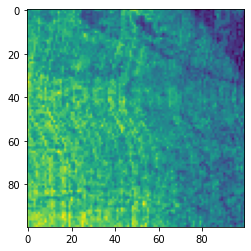

In [9]:
# view a section of the aviris scene
plt.imshow(X[100:200,100:200,4])

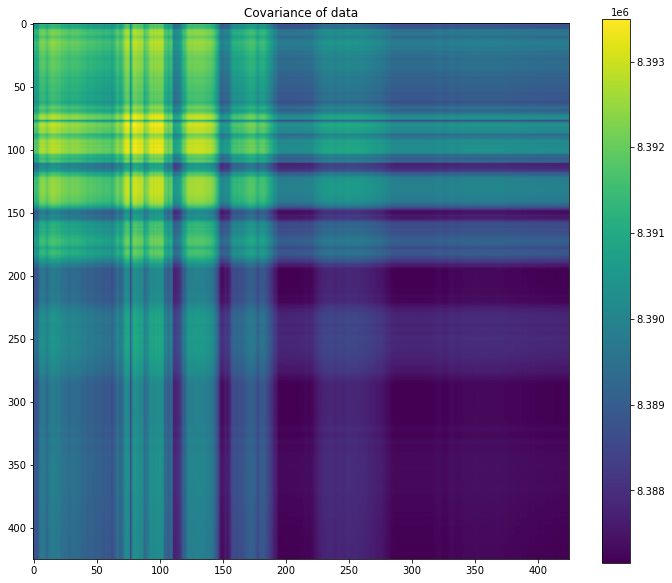

<Figure size 432x288 with 0 Axes>

In [10]:
# zero the deep water features and bad calibration in the extreme SWIR
opaque = np.logical_or(np.logical_and(aviris_wl>1280, aviris_wl<1450),
                       np.logical_and(aviris_wl>1750, aviris_wl<2000))
badcalibration = aviris_wl>2480
bad = np.logical_or(opaque, badcalibration)

X_reshape = X.reshape((nrow*ncol, nband))

## Get the background mean and covariance
# A subset of pixels is sufficient, say one out of every 100
subset = np.arange(0,X_reshape.shape[0],100)
Xsub = X_reshape[subset,:]
Xsub_masked = np.ma.masked_where(Xsub == -9999., Xsub)
mu = Xsub_masked.mean(axis=0) #background mean

# Calculate the covariance
Cov = np.cov(Xsub, rowvar=False);
plt.figure(figsize=(12,10))
plt.imshow(Cov)
plt.colorbar()
plt.title('Covariance of data')
plt.figure();

In [11]:
# view the methane coefficient data
ch4_Kcoef

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [12]:
ch4_Kcoef.shape

(425,)

## Calculate target signature and apply the MF

In [13]:
## Calculate the target signature
t = -mu*(ch4_Kcoef)

Apply the matched filter on the data. The mathed filter formula for a test spectrum $\bf x$, a background with mean $\mu$ and covariance matrix $\bf \Sigma$, and a target $\bf t$, is:
$$ \alpha(\bf x) = \frac{(x - \mu)^T\Sigma^{-1}t}{t^T \Sigma^{-1} t} $$

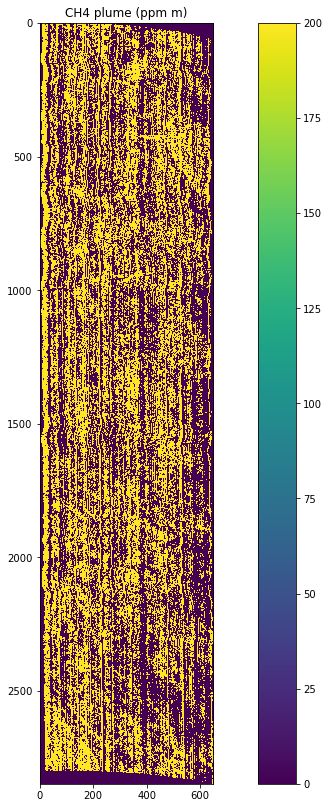

In [19]:
# Note that the signature is scaled by a factor of 1e-5, so you'll have
# to multiply the matched filter result by 10000 to get units of ppm m

# Add some regularization
Cinv = inv(Cov + np.eye(len(aviris_wl))*1e-8)
# Implement the matched filter
mf = ((X-mu).dot(Cinv.dot(t)))/(t.dot(Cinv.dot(t)))
# Reshape to the regular image shape
mf = mf.reshape((nrow, ncol))

# plot the ch4 plume
plt.figure(figsize=(16,14))
# plt.imshow(mf[0:250, 200:450] * 10000.0)
mf_subset = mf.copy()
mf_subset = mf_subset * 10000.0
plt.imshow(mf_subset)
plt.colorbar()
plt.clim([0,200])
plt.title('CH4 plume (ppm m)')
plt.imsave('MF2.png',mf*10000.0)

In [22]:
ch4_raster = rasterio.open('./ch4aviris.tif', 'w', driver='GTiff',
                           width=aviris_data.width, height = aviris_data.height,
                           crs=aviris_data.crs,
                           count=1,
                           transform=aviris_data.transform,
                           dtype='float64',
                           nodata = -9999)

# Write each band to the raster file
ch4_raster.write(mf_subset, 1) # write the red band

# Close the raster file
ch4_raster.close()

In [20]:
#############
## SCRATCH ##
#############